In [13]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport


from read import parse_raw_dataframe

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme(style="darkgrid")

In [14]:

import sys
sys.path.append('/home/cdanmontoya/.local/lib/python3.9/site-packages')

# Algunas preguntas

* ¿a qué horas ocurren las transacciones normalmente? ¿las fraudulentas?
* ¿cuál es el monto normal de las transacciones?
* ¿cuál es el monto de las transacciones fraudulentas comparado contra las normales?
* ¿cuántas transacciones realiza un usuario normalmente?
* ¿cuántas transacciones realiza un usuario que comete un fraude?
* ¿los usuarios intentar realizar más de un fraude? ¿qué tan seguido?
* ¿cómo se distribuyen según el tipo de dispositivo?
* ¿cómo se distribuyen por establecimiento?
* ¿física o virtual?
* ¿cuántas de las transacciones fraudulentas son aceptadas, rechazadas?
* ¿cuánto es el monto del cashback y del descuento en las transacciones fraudulentas

In [2]:
data = parse_raw_dataframe(pd.read_csv('MLE Challenge.csv', sep=';'))
data.head()

ID_USER genero       monto      fecha  hora establecimiento       ciudad  \
0        0      F  608.345633 2020-01-21    20           Super       Merida   
1        0      F   88.719243 2020-01-15     7             NaN       Merida   
2        1      F  790.037653 2020-01-17    11             NaN  Guadalajara   
3        1      F  767.005387 2020-01-05    11           MPago  Guadalajara   
4        1      F  254.171053 2020-01-30    10             NaN  Guadalajara   

   tipo_tc  linea_tc  interes_tc  status_txn  is_prime       dcto   cashback  \
0  FÃ­sica     71000        51.0    Aceptada     False  60.834563   5.475111   
1  Virtual     71000        51.0    Aceptada     False   0.000000   1.774385   
2  Virtual     94000        56.0  En proceso     False   0.000000  15.800753   
3  FÃ­sica     94000        56.0    Aceptada     False   0.000000   7.670054   
4  FÃ­sica     94000        56.0    Aceptada     False   0.000000   2.541711   

   fraude  model  device_score       os  
0   False   2020             3  ANDROID  
1   False   2020             1  ANDROID  
2   False   2020             1        ,  
3   False   2020             3      WEB  
4   False   2020             3       %%

In [16]:
profile = ProfileReport(data, title="Pandas Profiling Report", explorative=True)

In [17]:
profile.to_widgets()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

In [18]:
profile.to_file("your_report.html")

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [3]:
print(f'Cantidad de transacciones: {data.shape}')
print(f'Cantidad de usuarios: {len(pd.unique(data.ID_USER))}')

Cantidad de transacciones: (26975, 18)
Cantidad de usuarios: 4000


Tenemos unos datos fuertemente desbalanceados, las transacciones fraudulentas sólo representan un 3% del total de los datos

In [153]:
data.groupby('fraude').count()

ID_USER  genero  monto  fecha   hora  establecimiento  ciudad  \
fraude                                                                  
False     26165   26165  26165  26165  26165            16363   14841   
True        810     810    810    810    810              493     456   

        tipo_tc  linea_tc  interes_tc  status_txn  is_prime   dcto  cashback  \
fraude                                                                         
False     26165     26165       26165       26165     26165  26165     26165   
True        810       810         810         810       810    810       810   

        model  device_score     os  
fraude                              
False   26165         26165  26165  
True      810           810    810

<AxesSubplot:ylabel='Porcentaje de transacciones fraudulentas'>

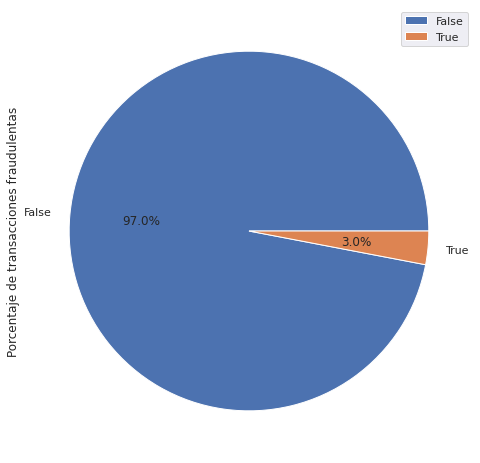

In [85]:
data.groupby('fraude').count().plot(kind='pie', y='ID_USER', autopct='%1.1f%%', label='Porcentaje de transacciones fraudulentas')

Establecimiento y ciudad son datos que tienen muchos valores nulos

In [139]:
data.isna().sum()

ID_USER                0
genero                 0
monto                  0
fecha                  0
hora                   0
establecimiento    10119
ciudad             11678
tipo_tc                0
linea_tc               0
interes_tc             0
status_txn             0
is_prime               0
dcto                   0
cashback               0
fraude                 0
model                  0
device_score           0
os                     0
dtype: int64

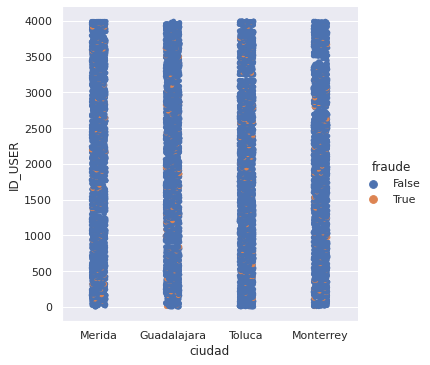

In [165]:
# Tenemos una distribución muy similar por ciudad
sns.catplot(data=data, x='ciudad', y='ID_USER',hue='fraude')

Las transacciones con ciudad incluyen una porción relevante de las transacciones fraudulentas

In [154]:
data[data.ciudad.isna()].groupby('fraude').count()

ID_USER  genero  monto  fecha   hora  establecimiento  ciudad  \
fraude                                                                  
False     11324   11324  11324  11324  11324             7081       0   
True        354     354    354    354    354              224       0   

        tipo_tc  linea_tc  interes_tc  status_txn  is_prime   dcto  cashback  \
fraude                                                                         
False     11324     11324       11324       11324     11324  11324     11324   
True        354       354         354         354       354    354       354   

        model  device_score     os  
fraude                              
False   11324         11324  11324  
True      354           354    354

## ¿a qué horas ocurren las transacciones normalmente? ¿las fraudulentas?

<AxesSubplot:ylabel='ID_USER'>

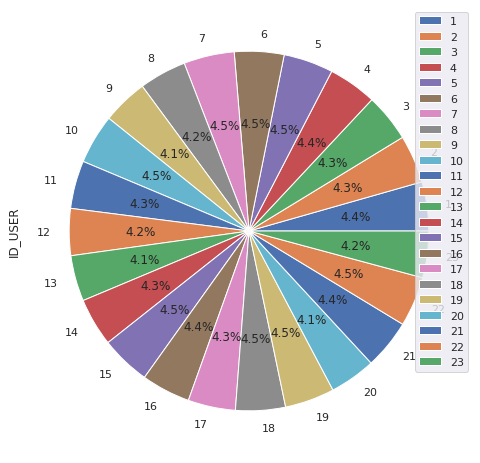

In [243]:
data.groupby('hora').count().plot(kind='pie', y='ID_USER', autopct='%1.1f%%')

<AxesSubplot:xlabel='hora', ylabel='ID_USER'>

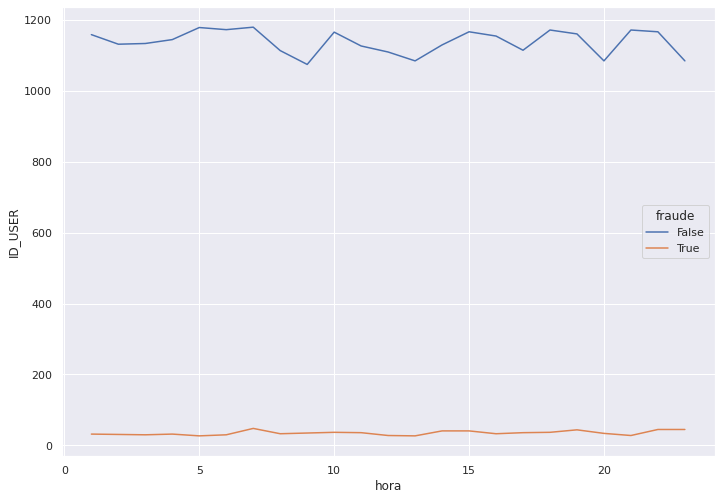

In [128]:
users_by_hour = data.groupby(['hora', 'fraude']).count().reset_index()
sns.lineplot(x=users_by_hour.hora, y=users_by_hour.ID_USER, data=users_by_hour, hue='fraude')

<AxesSubplot:title={'center':'hora'}, xlabel='[fraude]'>

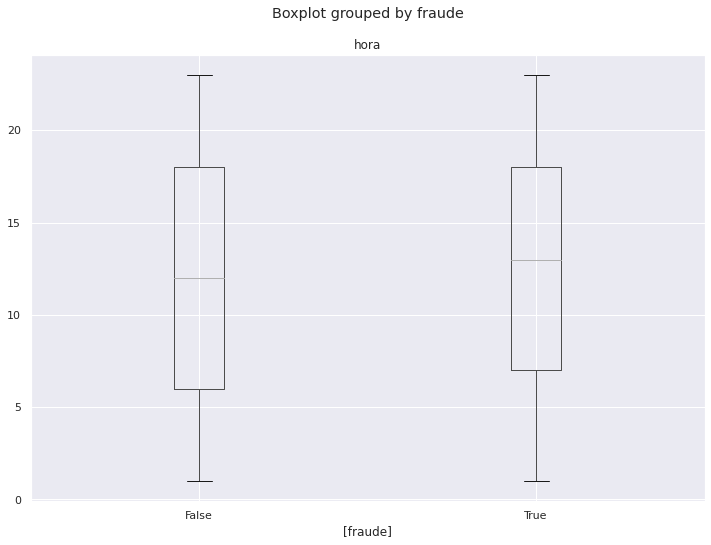

In [169]:
data.boxplot(column='hora', by=['fraude'])

In [171]:
# Las fechas también son bastante homogeneas
data.groupby('fecha').describe()

ID_USER                                                            \
             count         mean          std   min      25%     50%      75%   
fecha                                                                          
2020-01-02   940.0  1956.101064  1138.342137  13.0   990.50  1974.5  2893.00   
2020-01-03   913.0  2045.171961  1117.537920  12.0  1154.00  2040.0  3016.00   
2020-01-04   899.0  2010.057842  1154.490989   2.0  1027.50  1974.0  2995.50   
2020-01-05   950.0  1991.034737  1119.707200   1.0  1035.00  1991.0  2909.00   
2020-01-06   933.0  2006.936763  1136.810728   1.0  1051.00  2070.0  2911.00   
2020-01-07   961.0  2039.063476  1166.812784   2.0  1058.00  2004.0  3091.00   
2020-01-08   919.0  2036.361262  1129.629008   2.0  1104.00  2081.0  3001.50   
2020-01-09   912.0  1995.129386  1169.169532  14.0  1020.75  1991.5  2949.50   
2020-01-10   869.0  1975.326812  1146.387708  12.0   997.00  2024.0  2974.00   
2020-01-11   935.0  1968.360428  1141.130434   1.0  1007.50  1994.0  2888.00   
2020-01-12   969.0  1968.752322  1177.213924   8.0   912.00  1926.0  3008.00   
2020-01-13   935.0  2033.458824  1123.917566  13.0  1087.00  1979.0  3003.50   
2020-01-14   884.0  2117.527149  1138.047809   9.0  1176.25  2165.5  3087.50   
2020-01-15   952.0  2022.748950  1138.868124   0.0  1066.25  2023.5  2956.00   
2020-01-16   916.0  1958.661572  1169.980129   7.0   897.00  1942.0  3010.75   
2020-01-17   941.0  2013.579171  1129.122072   1.0  1102.00  2051.0  2946.00   
2020-01-18   936.0  1976.435897  1143.968113   2.0  1035.50  1908.0  2969.00   
2020-01-19   935.0  2069.542246  1120.848362   1.0  1130.50  2144.0  3011.50   
2020-01-20   927.0  1990.806904  1153.827823  14.0   997.00  1941.0  3000.00   
2020-01-21   920.0  1956.148913  1115.546062   0.0  1026.75  1887.5  2836.50   
2020-01-22   928.0  2041.676724  1176.916575   7.0  1049.50  2082.5  3046.50   
2020-01-23   891.0  1993.545455  1152.705139  18.0   969.50  1972.0  2971.00   
2020-01-24   966.0  1990.512422  1150.932148  19.0  1040.25  1958.0  2969.00   
2020-01-25   946.0  1956.984144  1147.701788   3.0  1017.00  1948.0  2918.00   
2020-01-26   926.0  1996.562635  1151.121076   2.0  1003.25  2029.0  2952.75   
2020-01-27   927.0  1987.035599  1139.710503   1.0  1039.50  1964.0  2985.00   
2020-01-28   914.0  1997.429978  1131.919648  11.0  1055.00  2024.0  2962.50   
2020-01-29   977.0  2014.256909  1143.234408   8.0  1041.00  2028.0  2949.00   
2020-01-30   954.0  2004.290356  1164.356625   1.0   968.00  2072.0  2994.75   

                    monto              ...   model         device_score  \
               max  count        mean  ...     75%     max        count   
fecha                                  ...                                
2020-01-02  3994.0  940.0  485.469531  ...  2020.0  2020.0        940.0   
2020-01-03  3999.0  913.0  498.406595  ...  2020.0  2020.0        913.0   
2020-01-04  3994.0  899.0  492.772945  ...  2020.0  2020.0        899.0   
2020-01-05  3994.0  950.0  493.235705  ...  2020.0  2020.0        950.0   
2020-01-06  3993.0  933.0  487.286394  ...  2020.0  2020.0        933.0   
2020-01-07  3998.0  961.0  496.732429  ...  2020.0  2020.0        961.0   
2020-01-08  3999.0  919.0  519.301640  ...  2020.0  2020.0        919.0   
2020-01-09  3996.0  912.0  496.921181  ...  2020.0  2020.0        912.0   
2020-01-10  3998.0  869.0  494.025905  ...  2020.0  2020.0        869.0   
2020-01-11  3995.0  935.0  493.997934  ...  2020.0  2020.0        935.0   
2020-01-12  3996.0  969.0  512.871137  ...  2020.0  2020.0        969.0   
2020-01-13  3999.0  935.0  472.266248  ...  2020.0  2020.0        935.0   
2020-01-14  3999.0  884.0  495.475681  ...  2020.0  2020.0        884.0   
2020-01-15  3994.0  952.0  514.443881  ...  2020.0  2020.0        952.0   
2020-01-16  3999.0  916.0  506.685259  ...  2020.0  2020.0        916.0   
2020-01-17  3998.0  941.0  509.086827  ...  2020.0  2020.0        941.0   
2020-01-18  3993.0  936.0

## ¿Cuál es el monto normal de las transacciones?

En general los montos de las transacciones son bastante parecidos cuando se analizan hasta dos variables, es a partir de incluir la tercera variable que se empiezan a notar grupos candidatos a separarse de los demás

<AxesSubplot:title={'center':'monto'}, xlabel='[fraude]'>

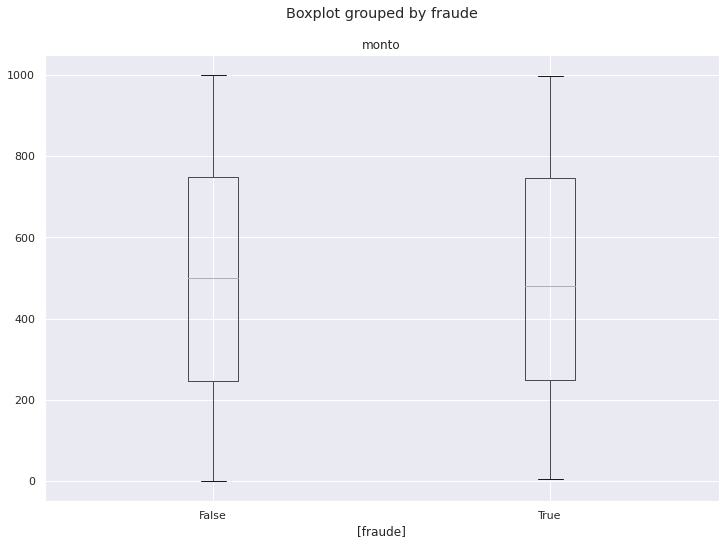

In [180]:
data.boxplot(column='monto', by=['fraude'])

In [178]:
# https://towardsdatascience.com/hypothesis-testing-in-machine-learning-using-python-a0dc89e169ce
from scipy.stats import f_oneway

F, p = f_oneway(data[data.fraude == True].monto, data[data.fraude == False].monto)
print("p-value for significance is: ", p)
if p<0.05:
    print("reject null hypothesis")
else:
    print("accept null hypothesis")

p-value for significance is:  0.4863257351730823
accept null hypothesis


<AxesSubplot:title={'center':'monto'}, xlabel='[fraude, ciudad]'>

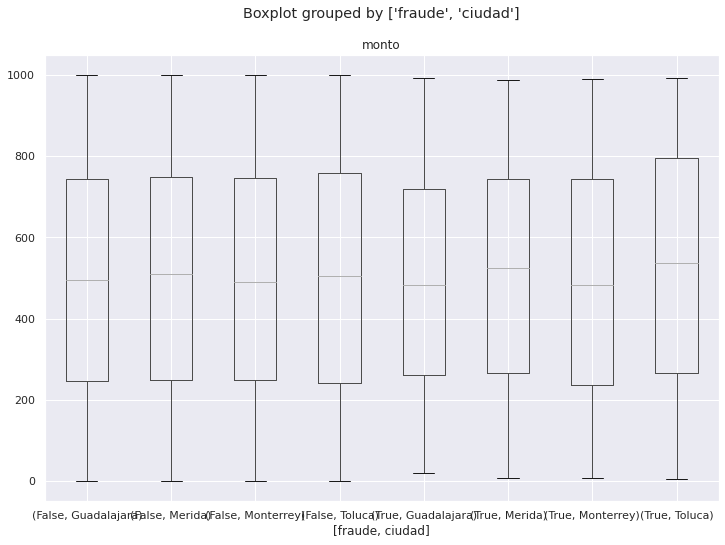

In [179]:
data.boxplot(column='monto', by=['fraude', 'ciudad'])

<AxesSubplot:title={'center':'monto'}, xlabel='[fraude, genero, status_txn]'>

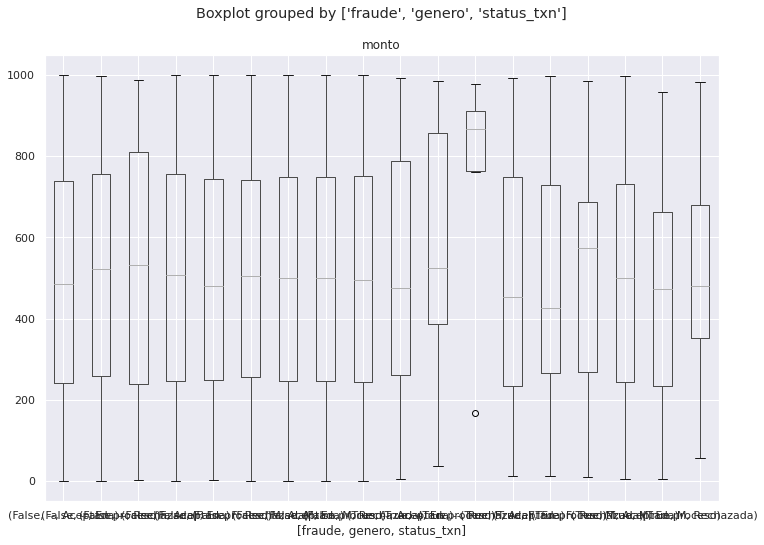

In [174]:
data.boxplot(column='monto', by=['fraude', 'genero', 'status_txn'])

## ¿cuántas transacciones realiza un usuario normalmente?

<AxesSubplot:title={'center':'monto'}, xlabel='fraude'>

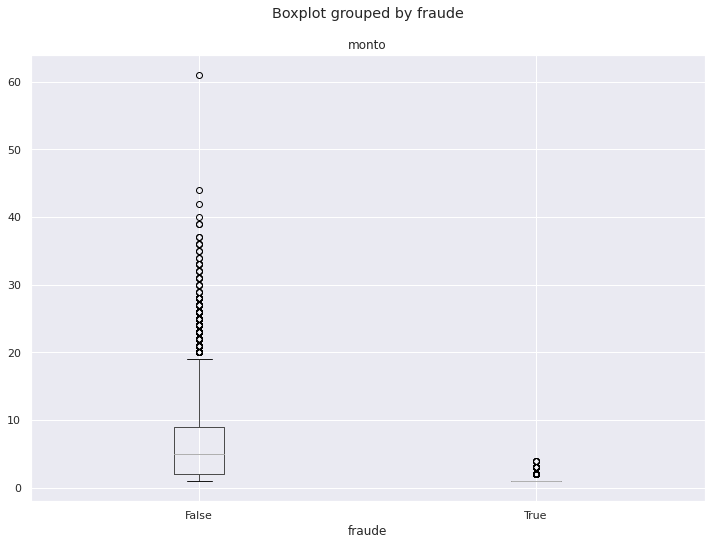

In [185]:
data.groupby(['ID_USER', 'fraude']).count().reset_index().boxplot(column='monto', by='fraude')

<AxesSubplot:title={'center':'monto'}, xlabel='fraude'>

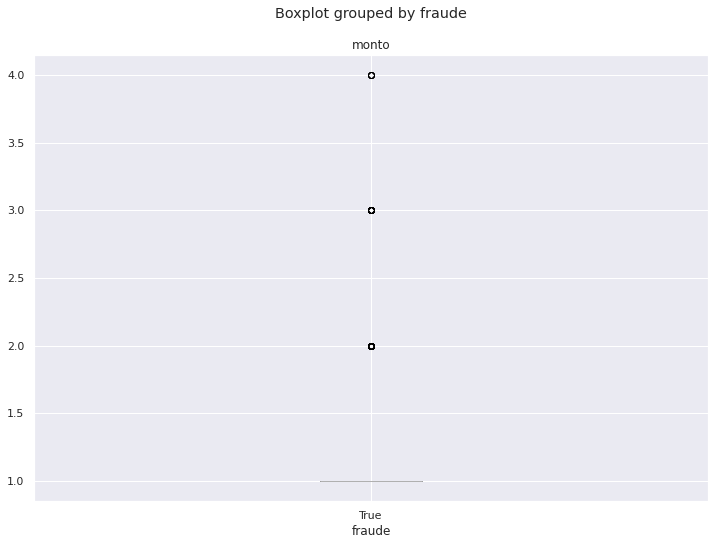

In [187]:
data[data.fraude == True].groupby(['ID_USER', 'fraude']).count().reset_index().boxplot(column='monto', by='fraude')

In [196]:
usuarios_fraudes = data[data.fraude == True].groupby('ID_USER').count()
usuarios_no_fraudes = data[data.fraude == False].groupby('ID_USER').count()

<AxesSubplot:xlabel='monto'>

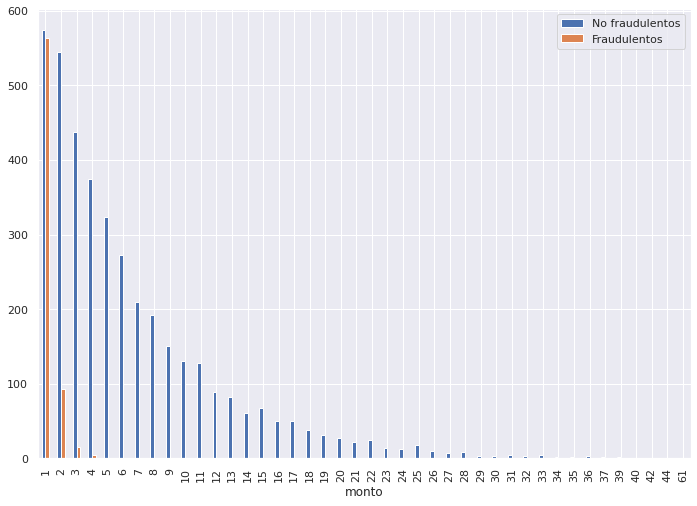

In [236]:
pd.DataFrame({'No fraudulentos': usuarios_no_fraudes.groupby('monto').count().genero, 'Fraudulentos': usuarios_fraudes.groupby('monto').count().genero}).plot.bar()

<AxesSubplot:xlabel='Reincidencias', ylabel='Usuarios'>

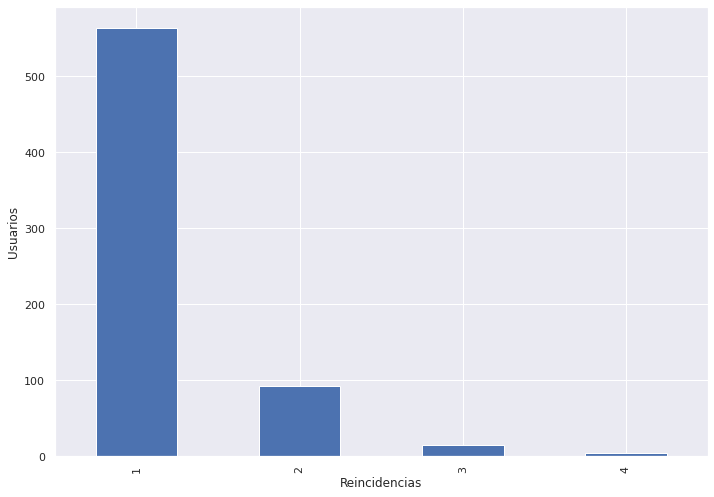

In [216]:
usuarios_fraudes.groupby('monto').count().genero.plot(kind='bar', xlabel='Reincidencias', ylabel='Usuarios')

In [276]:
# Muchas de las transacciones fraudulentas están aceptadas, y hay varias en proceso, deberíamos concentrarnos en identificar las que están en proceso para rechazarlas
data[data.fraude == True].groupby(['status_txn']).count()

ID_USER  genero  monto  fecha  hora  establecimiento  ciudad  \
status_txn                                                                 
Aceptada        570     570    570    570   570              332     322   
En proceso      162     162    162    162   162              111      92   
Rechazada        78      78     78     78    78               50      42   

            tipo_tc  linea_tc  interes_tc  is_prime  dcto  cashback  fraude  \
status_txn                                                                    
Aceptada        570       570         570       570   570       570     570   
En proceso      162       162         162       162   162       162     162   
Rechazada        78        78          78        78    78        78      78   

            model  device_score   os  
status_txn                            
Aceptada      570           570  570  
En proceso    162           162  162  
Rechazada      78            78   78

In [288]:
data[(data.fraude == True) & (data.status_txn == 'Aceptada')].groupby(['ID_USER']).count().sort_values('os')

genero  monto  fecha  hora  establecimiento  ciudad  tipo_tc  \
ID_USER                                                                 
5             1      1      1     1                0       1        1   
2594          1      1      1     1                1       1        1   
2583          1      1      1     1                1       1        1   
2582          1      1      1     1                0       1        1   
2563          1      1      1     1                1       0        1   
...         ...    ...    ...   ...              ...     ...      ...   
1395          3      3      3     3                2       3        3   
2423          3      3      3     3                1       0        3   
1671          3      3      3     3                0       3        3   
1872          3      3      3     3                1       3        3   
2845          3      3      3     3                3       3        3   

         linea_tc  interes_tc  status_txn  is_prime  dcto  cashback  fraude  \
ID_USER                                                                       
5               1           1           1         1     1         1       1   
2594            1           1           1         1     1         1       1   
2583            1           1           1         1     1         1       1   
2582            1           1           1         1     1         1       1   
2563            1           1           1         1     1         1       1   
...           ...         ...         ...       ...   ...       ...     ...   
1395            3           3           3         3     3         3       3   
2423            3           3           3         3     3         3       3   
1671            3           3           3         3     3         3       3   
1872            3           3           3         3     3         3       3   
2845            3           3           3         3     3         3       3   

         model  device_score  os  
ID_USER                           
5            1             1   1  
2594         1             1   1  
2583         1             1   1  
2582         1             1   1  
2563         1             1   1  
...        ...           ...  ..  
1395         3             3   3  
2423         3             3   3  
1671         3             3   3  
1872         3             3   3  
2845         3             3   3  

[507 rows x 17 columns]

In [280]:
data[data.fraude == True].groupby(['ID_USER']).count()

genero  monto  fecha  hora  establecimiento  ciudad  tipo_tc  \
ID_USER                                                                 
5             1      1      1     1                0       1        1   
7             1      1      1     1                1       1        1   
9             1      1      1     1                1       0        1   
14            1      1      1     1                0       1        1   
19            1      1      1     1                0       0        1   
...         ...    ...    ...   ...              ...     ...      ...   
3973          2      2      2     2                1       2        2   
3980          1      1      1     1                0       1        1   
3986          1      1      1     1                0       1        1   
3991          1      1      1     1                1       1        1   
3994          3      3      3     3                3       0        3   

         linea_tc  interes_tc  status_txn  is_prime  dcto  cashback  fraude  \
ID_USER                                                                       
5               1           1           1         1     1         1       1   
7               1           1           1         1     1         1       1   
9               1           1           1         1     1         1       1   
14              1           1           1         1     1         1       1   
19              1           1           1         1     1         1       1   
...           ...         ...         ...       ...   ...       ...     ...   
3973            2           2           2         2     2         2       2   
3980            1           1           1         1     1         1       1   
3986            1           1           1         1     1         1       1   
3991            1           1           1         1     1         1       1   
3994            3           3           3         3     3         3       3   

         model  device_score  os  
ID_USER                           
5            1             1   1  
7            1             1   1  
9            1             1   1  
14           1             1   1  
19           1             1   1  
...        ...           ...  ..  
3973         2             2   2  
3980         1             1   1  
3986         1             1   1  
3991         1             1   1  
3994         3             3   3  

[675 rows x 17 columns]

In [279]:
df['sales'] / df.groupby('state')['sales'].transform('sum')

NameError: name 'df' is not defined

## ¿cómo se distribuyen según el tipo de dispositivo?

<AxesSubplot:xlabel='os'>

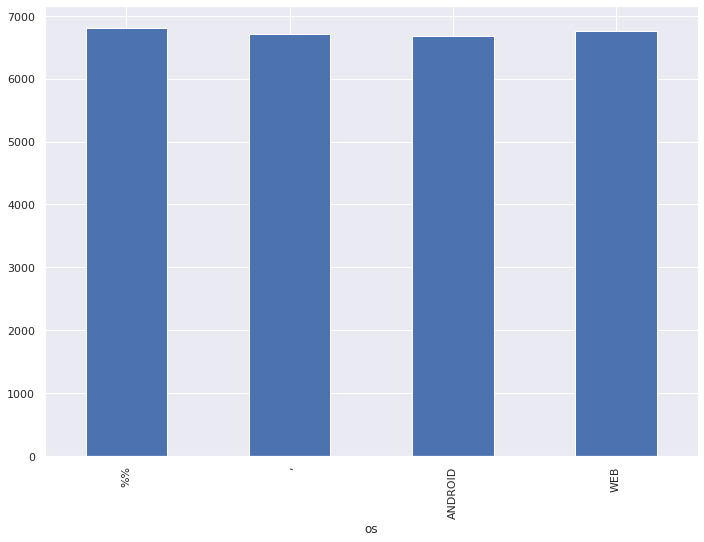

In [242]:
data.groupby('os').count().ID_USER.plot.bar()

In [246]:
jeje = data.groupby(['hora', 'fraude']).count().reset_index()
jeje = jeje[jeje.fraude == True]
jeje

hora  fraude  ID_USER  genero  monto  fecha  establecimiento  ciudad  \
1      1    True       32      32     32     32               23      22   
3      2    True       31      31     31     31               16      16   
5      3    True       30      30     30     30               17      14   
7      4    True       32      32     32     32               19      19   
9      5    True       27      27     27     27               16      14   
11     6    True       30      30     30     30               21      15   
13     7    True       48      48     48     48               31      28   
15     8    True       33      33     33     33               23      19   
17     9    True       35      35     35     35               22      22   
19    10    True       37      37     37     37               19      20   
21    11    True       36      36     36     36               23      21   
23    12    True       28      28     28     28               17      17   
25    13    True       27      27     27     27               14      14   
27    14    True       41      41     41     41               25      26   
29    15    True       41      41     41     41               28      24   
31    16    True       33      33     33     33               17      19   
33    17    True       36      36     36     36               21      21   
35    18    True       37      37     37     37               19      18   
37    19    True       44      44     44     44               24      29   
39    20    True       34      34     34     34               23      18   
41    21    True       28      28     28     28               17      14   
43    22    True       45      45     45     45               30      22   
45    23    True       45      45     45     45               28      24   

    tipo_tc  linea_tc  interes_tc  status_txn  is_prime  dcto  cashback  \
1        32        32          32          32        32    32        32   
3        31        31          31          31        31    31        31   
5        30        30          30          30        30    30        30   
7        32        32          32          32        32    32        32   
9        27        27          27          27        27    27        27   
11       30        30          30          30        30    30        30   
13       48        48          48          48        48    48        48   
15       33        33          33          33        33    33        33   
17       35        35          35          35        35    35        35   
19       37        37          37          37        37    37        37   
21       36        36          36          36        36    36        36   
23       28        28          28          28        28    28        28   
25       27        27          27          27        27    27        27   
27       41        41          41          41        41    41        41   
29       41        41          41          41        41    41        41   
31       33        33          33          33        33    33        33   
33       36        36          36          36        36    36        36   
35       37        37          37          37        37    37        37   
37       44        44          44          44        44    44        44   
39       34        34          34          34        34    34        34   
41       28        28          28          28        28    28        28   
43       45        45          45          45        45    45        45   
45       45        45          45          45        45    45        45   

    model  device_score  os  
1      32            32  32  
3      31            31  31  
5      30            30  30  
7      32            32  32  
9      27            27  27  
11     30            30  30  
13     48            48  48  
15     33            33  33  
17     35            35  35  
19     37            37  37  
21     36            36  36  
23     28         

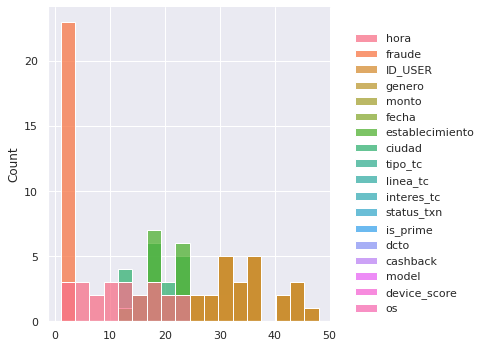

In [248]:
sns.displot(jeje)

<AxesSubplot:xlabel='establecimiento'>

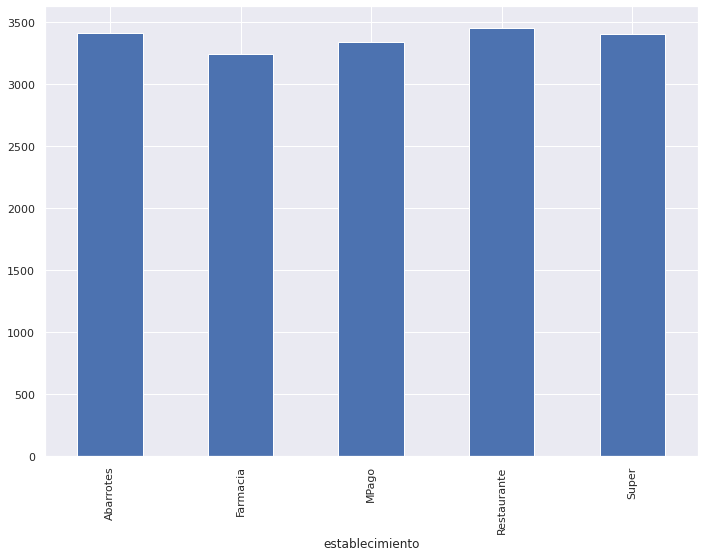

In [245]:
data.groupby('establecimiento').count().ID_USER.plot.bar()

<AxesSubplot:xlabel='interes_tc', ylabel='ID_USER'>

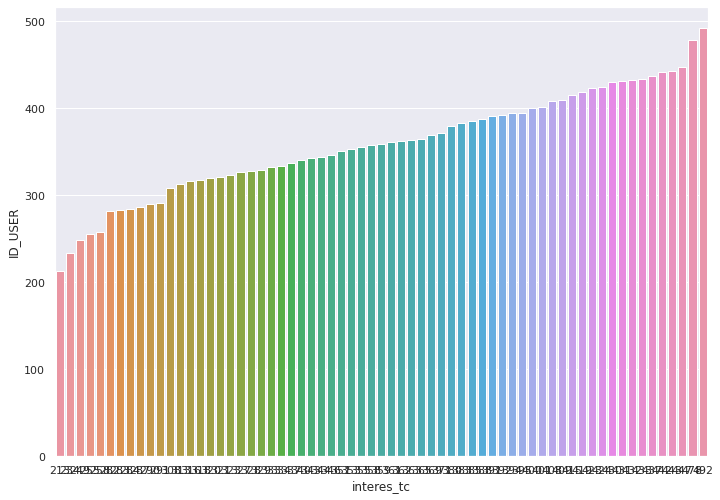

In [264]:
temp = data.groupby('linea_tc').count().reset_index()
sns.barplot(x=temp.interes_tc, y=temp.ID_USER)

<AxesSubplot:xlabel='interes_tc', ylabel='ID_USER'>

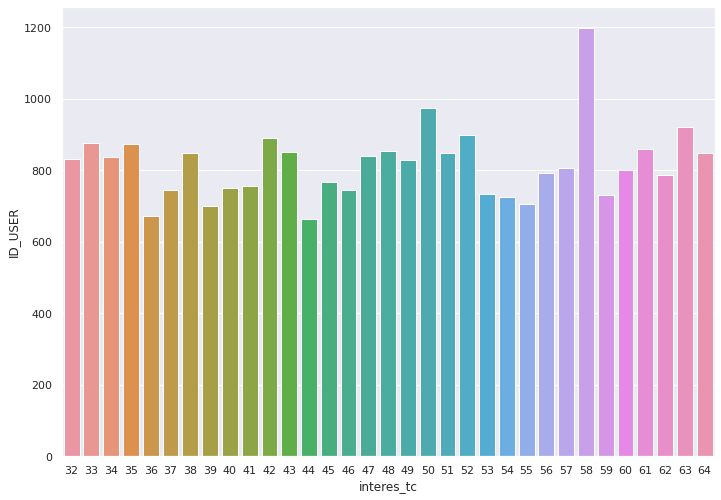

In [258]:
temp = data.groupby('interes_tc').count().reset_index()
sns.barplot(x=temp.interes_tc, y=temp.ID_USER)

<AxesSubplot:title={'center':'dcto'}, xlabel='[fraude]'>

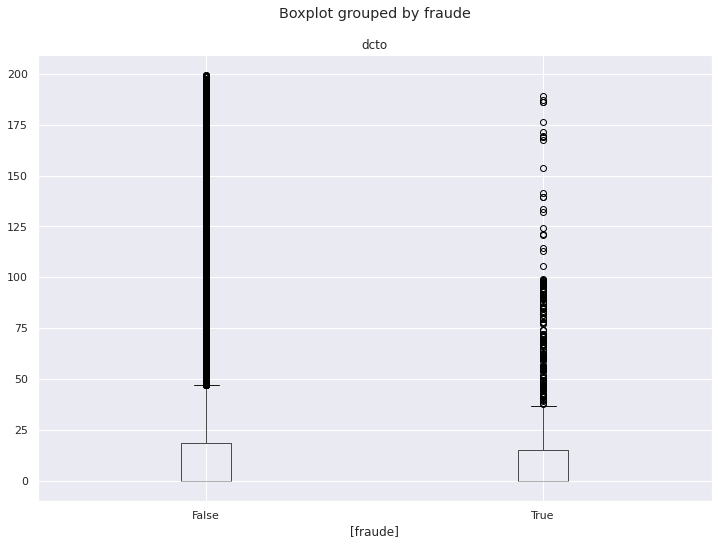

In [271]:
data.boxplot(column='dcto', by=['fraude'])

In [273]:
data.sort_values('dcto')

ID_USER genero       monto      fecha  hora establecimiento  \
26974     3999      M  517.209272 2020-01-03    20           MPago   
14728     2186      M   19.477995 2020-01-06     6       Abarrotes   
14727     2185      F  747.999477 2020-01-10    23             NaN   
14726     2185      F  475.312714 2020-01-21    11             NaN   
14725     2184      M  653.977498 2020-01-30    18           MPago   
...        ...    ...         ...        ...   ...             ...   
12413     1849      M  994.180242 2020-01-25    16       Abarrotes   
5563       840     --  994.507709 2020-01-05    18       Abarrotes   
3345       514      M  995.283848 2020-01-16     9             NaN   
19831     2918      F  995.704560 2020-01-13    14             NaN   
20728     3054      F  996.781256 2020-01-25     8           MPago   

            ciudad  tipo_tc  linea_tc  interes_tc  status_txn  is_prime  \
26974       Toluca  FÃ­sica     40000          56  En proceso     False   
14728       Merida  FÃ­sica     84000          45   Rechazada     False   
14727          NaN  Virtual     88000          49    Aceptada     False   
14726          NaN  Virtual     88000          49  En proceso     False   
14725       Merida  FÃ­sica     86000          57    Aceptada     False   
...            ...      ...       ...         ...         ...       ...   
12413  Guadalajara  FÃ­sica     71000          33    Aceptada     False   
5563   Guadalajara  Virtual     95000          59    Aceptada     False   
3345     Monterrey  Virtual     82000          34    Aceptada     False   
19831       Toluca  FÃ­sica     77000          53  En proceso     False   
20728  Guadalajara  FÃ­sica     74000          50    Aceptada      True   

             dcto   cashback  fraude  model  device_score       os  
26974    0.000000   5.172093   False   2020             5  ANDROID  
14728    0.000000   0.194780   False   2020             1       %%  
14727    0.000000  14.959990   False   2020             4        ,  
14726    0.000000   9.506254   False   2020             5      WEB  
14725    0.000000   6.539775   False   2020             2        ,  
...           ...        ...     ...    ...           ...      ...  
12413  198.836049   7.953442   False   2020             5      WEB  
5563   198.901542  15.912123   False   2020             4        ,  
3345   199.056770  15.924542   False   2020             2      WEB  
19831  199.140912   7.965636   False   2020             3        ,  
20728  199.356251   7.974250   False   2020             5        ,  

[26975 rows x 18 columns]